In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as spy

# Creating Desired Motion Profiles

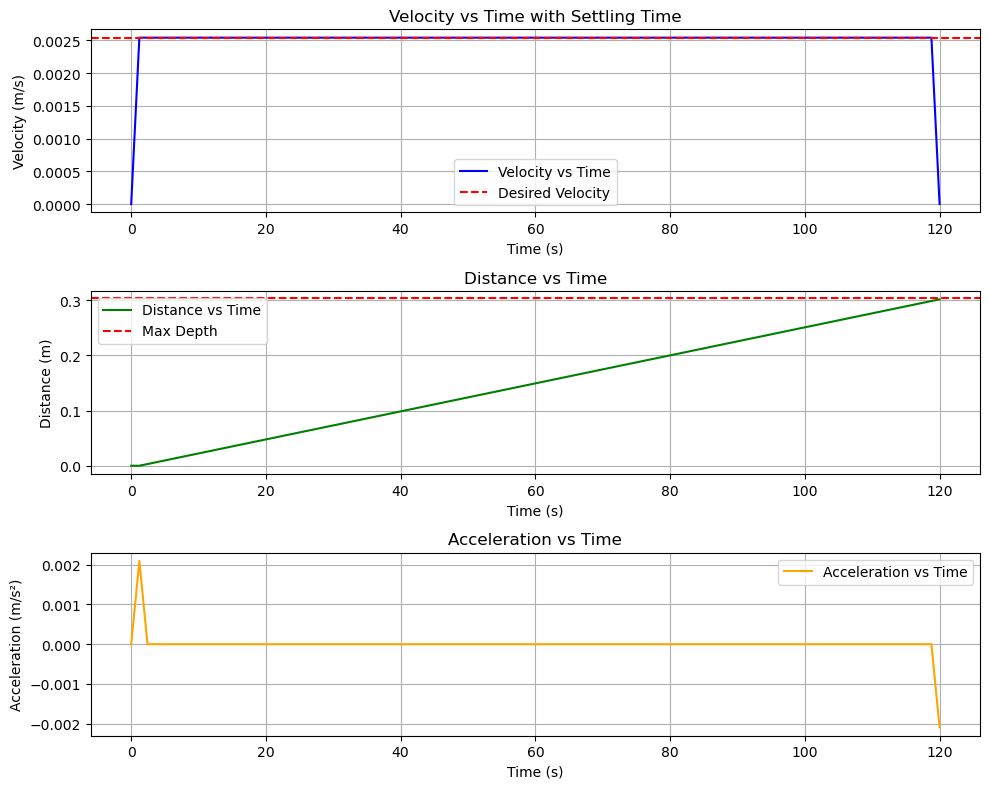

In [23]:
g = 9.81
# Constants
z_max = 12 * 0.0254  # Depth into soil (m)
t_total = 2 * 60     # Total time to go down (s)
t_settle = 1        # Time to reach constant velocity (s)

# Calculate the desired constant velocity
z_dot_desired = z_max / t_total  # Desired velocity (m/s)

# Create time array
time = np.linspace(0, t_total, 100)

# Initialize velocity, distance, and acceleration arrays
z_dot = np.zeros_like(time)
z = np.zeros_like(time)
z_ddot = np.zeros_like(time)

# Fill velocity array based on time
for i, t in enumerate(time):
    if t < t_settle:
        # During settling time (acceleration phase)
        z_dot[i] = (z_dot_desired / t_settle) * t  # Linear increase to desired velocity
    elif t < t_settle + (t_total - t_settle):
        # During constant velocity phase
        z_dot[i] = z_dot_desired
    else:
        # After constant velocity phase (deceleration to stop)
        z_dot[i] = 0  # Assuming it comes to a stop at the end

# Integrate velocity to get distance traveled
for i in range(1, len(time)):
    z[i] = z[i-1] + z_dot[i-1] * (time[i] - time[i-1])  # Simple numerical integration

# Calculate acceleration based on the change in velocity
for i in range(1, len(time)):
    z_ddot[i] = (z_dot[i] - z_dot[i-1]) / (time[i] - time[i-1])  # Numerical differentiation

# Create a DataFrame
df = pd.DataFrame({'t (s)': time, 'z (m)': z, 'z_dot (m/s)': z_dot, 'z_ddot (m/s²)': z_ddot})

# Plotting
plt.figure(figsize=(10, 8))

# Plot Velocity vs Time
plt.subplot(3, 1, 1)
plt.plot(df['t (s)'], df['z_dot (m/s)'], label='Velocity vs Time', color='blue')
plt.axhline(y=z_dot_desired, color='red', linestyle='--', label='Desired Velocity')
plt.title('Velocity vs Time with Settling Time')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.grid()
plt.legend()

# Plot Distance vs Time
plt.subplot(3, 1, 2)
plt.plot(df['t (s)'], df['z (m)'], label='Distance vs Time', color='green')
plt.axhline(y=z_max, color='red', linestyle='--', label='Max Depth')
plt.title('Distance vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Distance (m)')
plt.grid()
plt.legend()

# Plot Acceleration vs Time
plt.subplot(3, 1, 3)
plt.plot(df['t (s)'], df['z_ddot (m/s²)'], label='Acceleration vs Time', color='orange')
plt.title('Acceleration vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s²)')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()


In [24]:
##Robot Paramaters

a = 3.25 * 0.0254      #Diameter of external casing (m)
b = 3 * 0.0254      #Diameter of internal payload (m)


A_o = np.pi*(a**2)*(1/4) #Outer cross-sectional area (m^2)
A_i = np.pi*(b**2)*(1/4)  #Inner cross-sectional area (m^2)
A_slant = (a**2 - b**2)
df['A_s (m^2)'] = np.pi*a*df['z (m)']
df['A_s_i (m^2)'] = np.pi*b*df['z (m)']

del_z = 0.05*0.0254  #Height of chamfer (m)
theta_c= 30 #Angle of chamfer (deg)
theta_c_rad = np.radians(theta_c)

M = 11/2.2     #Mass of robot (kg)
W = M*g     #Weight of robot



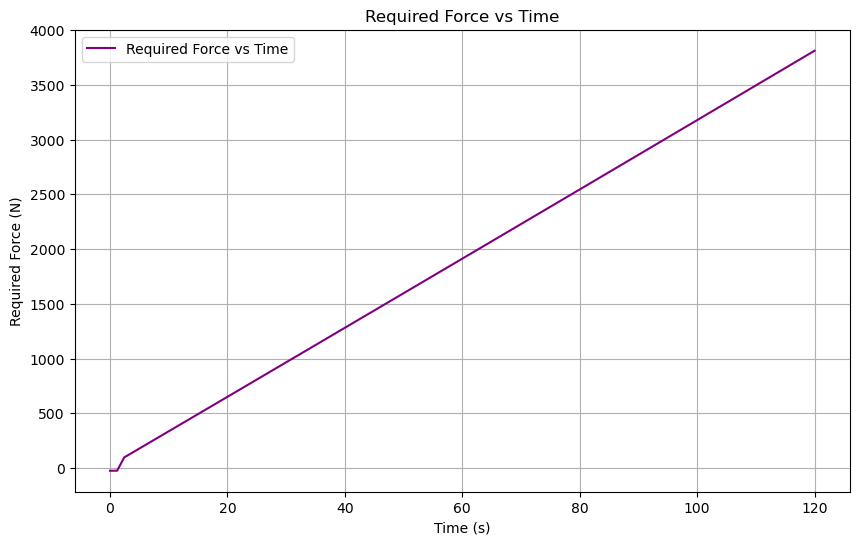

Maximum force required :3812.481069117592


In [25]:
## Soil Parameters (assume medium cohesive soil)
gamma = 1.5e3   #Unit wight of soil (N/m^3)
c= 95.76e3       #Effective cohesion of soil (Pa)  (2000 psf) -Clayey soils
phi = 30        #Friction angle of soil (deg)
rho = 1300      #Density of soil (kg/m^3)   

phi_rad = np.radians(phi)   
K_p = (1 + np.sin(phi_rad)) / (1 - np.sin(phi_rad)) #Passive pressure coefficient
K_a = (1 - np.sin(phi_rad)) / (1 + np.sin(phi_rad)) #active pressure coefficient

## Forces setup
#Friction_O is the friction on the outer walls (acts updwards)
df['F_friction_o (N)'] = (1/2)*df['A_s (m^2)']*np.tan(phi_rad)*(gamma*K_p*df['z (m)'] + 2*c*np.sqrt(K_p))

#Friction_i is the friction on the inner walls  (acts downwards
df['F_friction_i (N)'] = 0 #(-1/2)*df['A_s_i (m^2)']*np.tan(phi_rad)*(gamma*K_a*df['z (m)'] - 2*c*np.sqrt(K_p))


# Soil static force acting at chamfer at bottom
df['F_soil_static (N)'] = np.where(
    df['z (m)'] > 0,
    1/2 * A_slant *np.sin(theta_c_rad)*(gamma * K_p * (2 * df['z (m)'] + del_z) + 4 * c * np.sqrt(K_p)),
    0
)

# Required input force calculation
df['F_input (N)'] = (M+rho*A_i*df['z (m)'])*(df['z_ddot (m/s²)'] - g)+ df['F_soil_static (N)'] + df['F_friction_o (N)'] - df['F_friction_i (N)']
df['F_input (N)'] = df['F_input (N)']/2


# Plotting
plt.figure(figsize=(10, 6))

# Plot Required Force vs Time
plt.plot(df['t (s)'], df['F_input (N)'], label='Required Force vs Time', color='purple')
plt.title('Required Force vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Required Force (N)')
plt.grid()
plt.legend()
plt.show()

print(f"Maximum force required :{np.max(df['F_input (N)'])}")


In [26]:
##Gear Design
r_driver = 1 * 0.0254
N_driver = 16
N_pinion = 64

gear_ratio = N_pinion/N_driver

T_required = np.max(df['F_input (N)'])*r_driver/gear_ratio
print(T_required)



24.209254788896708
